# Estimating Landscape Features with LEAP

As you can imagine, the **structure of a fitness landscape** has a big impact of the ability of an evolutionary algorithm to find high-quality optima.

## Why Landscape Properties?

From practical experience and the famous No Free Lunch theorems for optimization, we know that no single optimization algorithm is better than all others at all problems.  Every algorithm performs better on some problems than on others.

Many challenges in optimization and machine learning boil down to "what kind of problems is my algorithm good at?" or, more pressingly, "what kind of algorithm can solve my problem?"

If we can understand the properties of problems---and what makes them harder or easier and for which algorithms---then we ought to be able to solve them more easily. The concept of a "fitness landscape" serves as a unifying view for a lot of these conversations.


# Landscape Difficulty

Early work on landscape analysis aimed to understand what (white-box) mathematical properties make some problems easy and other problems hard (for specific EAs like genetic algorithms).  For example, features like the following can make a problem difficult:

 - a landscape with **many local optima** is often harder to solve than a landscape with a single optimum,
 - a landscape with **deception**, i.e. a wide basin of attraction and fitness gradient that "leads toward" a low-quality local optimum, can be very difficult to solve, and
 - a landscape with **epistasis**, i.e. a non-linear intraction between two or more variables and the fitness surface, is often harder to solve than a problem that is separable into linear sub-problems.


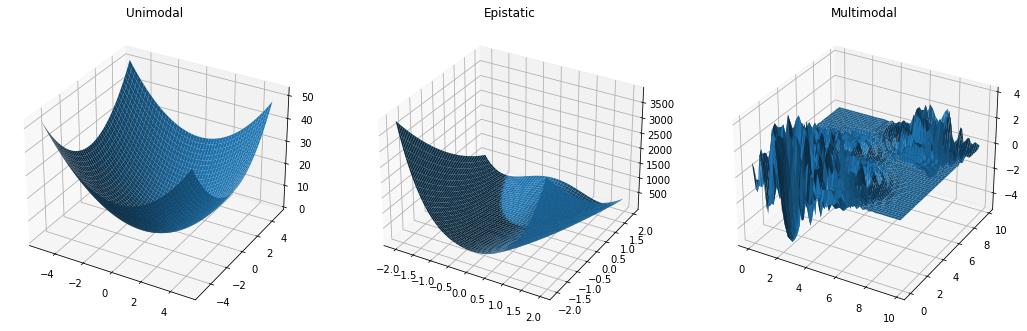

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

from leap_ec.real_rep import problems

plt.figure(figsize=(18, 6))

plt.subplot(131, projection='3d')
spheroid = problems.SpheroidProblem()
problems.plot_2d_problem(spheroid, xlim=spheroid.bounds, ylim=spheroid.bounds, ax=plt.gca(), title="Unimodal")

plt.subplot(132, projection='3d')
rosenbrock = problems.RosenbrockProblem()
problems.plot_2d_problem(rosenbrock, xlim=rosenbrock.bounds, ylim=rosenbrock.bounds, ax=plt.gca(), title="Epistatic")

plt.subplot(133, projection='3d')
langermann = problems.LangermannProblem()
problems.plot_2d_problem(langermann, xlim=langermann.bounds, ylim=langermann.bounds, ax=plt.gca(), title="Multimodal");

<div class="alert alert-block alert-info"><b>Note</b>: It's worth noting that there are exceptions to our intuitions about landscape difficulty.  Research has shown that multi-modal problems are not always hard for EAs (<a href="#HornGoldberg1995">Horn & Goldberg, 1995</a>), unimodal problems are not always easy (as shown by the classic "long-path" problems; <a href="#HornEtAl1994">Horn et al., 1994</a>; <a href="#KallelEtAl1999">Kallel et al., 1999</a>). Likewise, deceptive problems are not always hard (<a href="#Wilson1991">Wilson, 1991</a>), and non-deception doesn't not imply easiness (<a href="#VoseWright1995">Vose & Wright, 1995</a>).</div>

# Statistical Landscape Features

Today, research in this area tends to focus less on understanding problem difficulty and more on using information about a problem's landscape to help with <b>algorithm selection</b>.

## Exploratory Landscape Analysis


In particular, **exploratory landscape analysis** (ELA) is a set of such techniques that focuses on measuring statistical properties of *continuous optimization problems* by using a limited number of samples.  The idea behind ELA is that we can take a reasonable number of fitness samples---maybe a few dozen or hundred per dimension of the space---and compute many different statistical features to get a high-dimensional characterization of the landscape's structure.

ELA's canonical set of 50 fatures was established by Mersmann et al. (<a href="#MersmannEtAl2011">Mersmann et al., 2011</a>) and then considerably extended by the work of Pascal Kerschke and colleagues (<a href="#KerschkeEtAl2014">Kerschke et al., 2014</a>).  For a broader discussion of modern landscape analysis approaches (not just ELA), see the excellent review by Katherine Malan (<a href="#Malan2021">Malan, 2021</a>).

## Example: Convexity Features

LEAP's support for ELA is provided by the `leap_ec.landscape_features.exploratory` package.

The simplest class of ELA features estimate the _convexity_ of the landscape.  For details on how these work, have a look at the docs for <a href="https://leap-gmu.readthedocs.io/en/develop/leap_ec.landscape_features.html#leap_ec.landscape_features.exploratory.ELAConvexity">`ELAConvexity`</a>.

In LEAP, we can measure the features of a landscape by writing a function like this, based around a `problem` and making use of `ELAConvexity`:

In [2]:
from leap_ec.individual import Individual
from leap_ec.landscape_features import exploratory
from leap_ec.representation import Representation
from leap_ec.real_rep import initializers, problems


def measure_landscape(problem, dimensions=2):
    """Measure convexity features from the given problem, using a
    real-vector intializer to sample points."""
    # The purpose of ELA is to learn as much as we can from relatively few samples
    N_SAMPLES = 50*dimensions

    # In order to sample the landscape, we'll need a problem representation
    representation = Representation(
        initialize=initializers.create_real_vector(bounds=[(-5.12, 5.12)]*dimensions)
    )
    
    # Collect samples the same way we create populations
    initial_sample = representation.create_population(N_SAMPLES, problem)
    
    # Evaluate the fitness of each sample point ahead of time
    Individual.evaluate_population(initial_sample);
    
    # Compute landscape feautres from the samples.
    # This uses the representation to generate additional samples as needed
    convex = exploratory.ELAConvexity(problem, representation, design_individuals=initial_sample)
    
    # Return the resulting features as a handy DataFrame
    return convex.results_table()

<div class="alert alert-block alert-info"><b>Note</b>: Notice that in order to use LEAP's implementation of ELA features, we first define a <b>representation</b>.  The representation object defines how we collect samples.  By passing it into the ELA object, along with oan initial sample, we're telling it "here, you can use this to sample more points if you need to."</div>

Armed with this function, let's use it to measure the properties of the three problems we discussed above.  Since `ELAConvexity` provides us with a convenient DataFrame of all the features it knows how to calculate, it's easy to assemble the result into a table:

In [3]:
import pandas as pd

# Collect landscape features from several problems into a combined DataFrame
df = pd.concat([ measure_landscape(problems.SpheroidProblem()),
                 measure_landscape(problems.RosenbrockProblem()),
                 measure_landscape(problems.LangermannProblem())])

df = df.set_index('Function')
df

,P(convex),P(linear),Linear_deviation,Linear_deviation_abs
Function,,,,
SpheroidProblem,1.000,0.0,-5.989409,5.989409
RosenbrockProblem,0.987,0.0,-8050.938688,8055.538730
LangermannProblem,0.504,0.0,-0.040060,0.650376


Tables are hard to read, though, so let's flip that around into a bar plot.  We'll give it a logarithmic axis, since the Rosenbrok has some pretty big values.

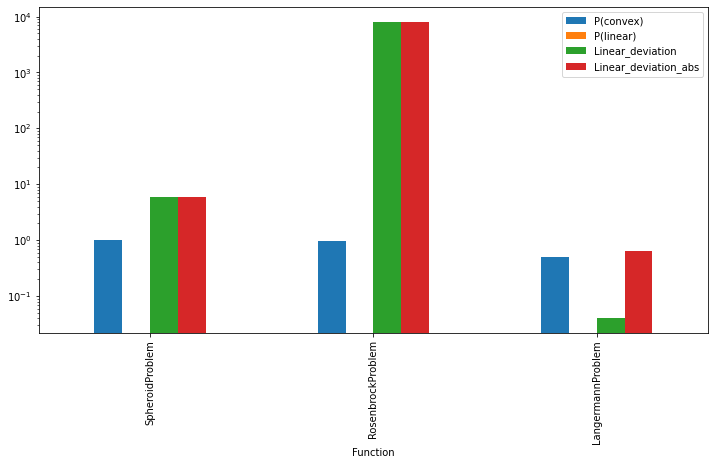

In [4]:
plt.figure(figsize=(12, 6))

# Flip the sign on Linear_deviation for visualization purposes
df.Linear_deviation = abs(df.Linear_deviation)

# Make a bar plot with a log scale
df.plot(kind='bar', ax=plt.gca())
plt.yscale('log')

As we'd expect, the Spheroid comes out as highly <span style="color: blue"><b>convex</b></span>.  But so does the Rosenbrock, and even the Langermann (which we wouldn't consider close to convex) has comes out as about 50% convex by this metric.

The <span style="color: green"><b>deviation from linearity</b></span> shows bigger differences between the functions.  The Rosenbrock's quadratic growth gives a big absolute magnitude to its fitness values, allowing it to rack up some pretty big non-convexity scores along this feature.

In general though, what we tend to see from analysis like these is that statistical features are <b>rarely human interpretable</b>.  The goal here is often to use these features to inform a machine learning process, using landscape features to learn to <i>predict</i> things like how well a given algorithm will perform on a given problem.

# References

 
 - <a name="HornGoldberg1995"></a>Horn, Jeffrey, and David E. Goldberg. "Genetic algorithm difficulty and the modality of fitness landscapes." *Foundations of genetic algorithms*. Vol. 3. Elsevier, 1995. 243-269.
 
 
 - <a name="HornEtAl1994"></a>Horn, Jeffrey, David E. Goldberg, and Kalyanmoy Deb. "Long path problems." *International Conference on Parallel Problem Solving from Nature*. Springer, Berlin, Heidelberg, 1994.
 
 
 - <a name="KallelEtAl1999"></a>Kallel, Leila, et al. "Candidate longpaths for the simple genetic algorithm." *Foundations of Genetic Algorithms* 5 (1999): 27-44.
 
 
 - <a name="KerschkeEtAl2014"></a>Kerschke, Pascal, et al. "<a href="https://link.springer.com/chapter/10.1007/978-3-319-07494-8_9">Cell mapping techniques for exploratory landscape analysis</a>." *EVOLVE-A Bridge between Probability, Set Oriented Numerics, and Evolutionary Computation V.* Springer, Cham, 2014. 115-131.
 
 
 - <a name="Malan2021"></a>Malan, Katherine Mary. "<a href="https://www.mdpi.com/1999-4893/14/2/40">A Survey of Advances in Landscape Analysis for Optimisation</a>." *Algorithms* 14.2 (2021): 40.
 
 
 - <a name="MersmannEtAl2011"></a>Mersmann, Olaf, et al. "<a href="https://dl.acm.org/doi/abs/10.1145/2001576.2001690">Exploratory landscape analysis</a>." *Proceedings of the 13th annual conference on Genetic and evolutionary computation.* 2011.
 
 
 - <a name="VoseWright1995"></a>Vose, Michael D., and Alden H. Wright. "Stability of vertex fixed points and applications." Foundations of genetic algorithms. Vol. 3. Elsevier, 1995. 103-113.
 
 
 - <a name="Wilson1991"></a>Wilson, Stewart W., and SW Wilson Ga-easy. "GA-Easy Does Not Imply Steepest-Ascent Optimizable." *Proceedings of the 4th International Conference on Gentic Algorithms*. 1991.